In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:

# Read TSV (tab-separated)
df = pd.read_csv("/content/amazonreviews.tsv", sep="\t", encoding="utf-8")


In [7]:

# Quick look
print(df.shape)
print(df.label.value_counts())
df.head()


(10000, 2)
label
neg    5097
pos    4903
Name: count, dtype: int64


,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [8]:
df

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
9995,pos,A revelation of life in small town America in ...
9996,pos,Great biography of a very interesting journali...
9997,neg,Interesting Subject; Poor Presentation: You'd ...
9998,neg,Don't buy: The box looked used and it is obvio...


In [9]:
df.drop_duplicates(inplace=True)
df.dropna(subset=["review"], inplace=True)

In [10]:

# Function for cleaning text
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\[.*?\]', '', text)  # remove text in brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove links
    text = re.sub(r'<.*?>+', '', text)  # remove HTML
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub(r'\n', '', text)  # remove line breaks
    text = re.sub(r'\w*\d\w*', '', text)  # remove words with numbers
    return text

df["clean_review"] = df["review"].apply(clean_text)

In [11]:
# Remove stopwords
stop_words = set(stopwords.words("english"))
df["clean_review"] = df["clean_review"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)

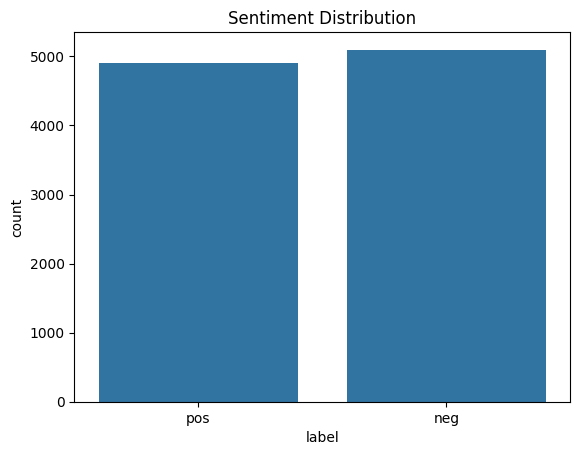

In [12]:
# Sentiment distribution
sns.countplot(data=df, x="label")
plt.title("Sentiment Distribution")
plt.show()


In [13]:

# Wordclouds
pos_text = " ".join(df[df["label"]=="pos"]["clean_review"])
neg_text = " ".join(df[df["label"]=="neg"]["clean_review"])

In [14]:
wordcloud_pos = WordCloud(width=600, height=400, background_color="white").generate(pos_text)
wordcloud_neg = WordCloud(width=600, height=400, background_color="black").generate(neg_text)

Text(0.5, 1.0, 'Positive Reviews WordCloud')

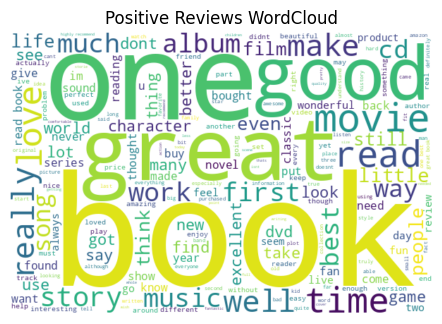

In [15]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews WordCloud")

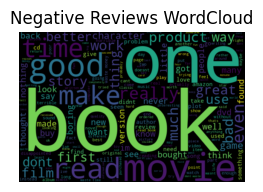

In [16]:
plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews WordCloud")
plt.show()

In [17]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_review"]).toarray()
y = df["label"].map({"pos":1, "neg":0})  # encode labels


In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [20]:
# Support Vector Machine (Linear)
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [21]:
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1037
           1       0.83      0.85      0.84       963

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Accuracy: 0.844


In [22]:
print("\nSupport Vector Machine Results:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))



Support Vector Machine Results:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1037
           1       0.84      0.83      0.83       963

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Accuracy: 0.839


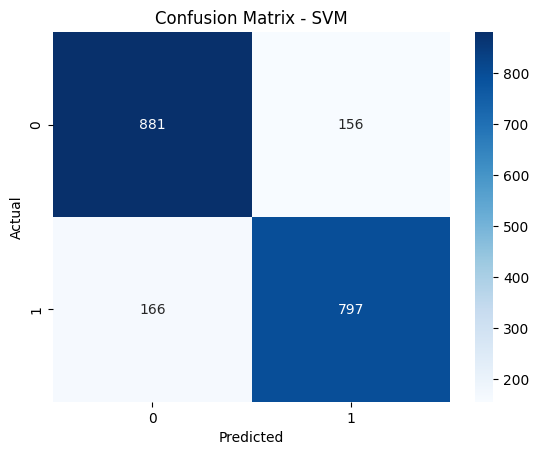

In [23]:

# Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Results Summary

### Logistic Regression
- **Accuracy:** 84.4%
- **Precision (Positive class = 1):** 0.83
- **Recall (Positive class = 1):** 0.85
- **F1-score (Positive class = 1):** 0.84

Interpretation:
- Logistic Regression is slightly better at **catching positive reviews** (higher recall for class 1).
- This makes it useful if the business wants to minimize missing *negative feedback masked as positive*.

---

### Support Vector Machine (SVM)
- **Accuracy:** 83.9%
- **Precision (Positive class = 1):** 0.84
- **Recall (Positive class = 1):** 0.83
- **F1-score (Positive class = 1):** 0.83

Interpretation:
- SVM shows **higher precision but slightly lower recall** for the positive class.
- This means SVM is more cautious — it avoids false positives but may miss some actual positive reviews.

---

### Overall Comparison
- Both models achieve nearly identical **accuracy (~84%)**.
- Logistic Regression edges out slightly in **recall**, making it better for ensuring that important reviews (especially negatives) are captured.
- SVM edges out slightly in **precision**, making it better for reducing false alarms.

 **Recommendation**:  
For a business problem focused on **early detection of customer dissatisfaction**, **Logistic Regression** may be more s
